In [1]:
# Imports
from typing import List
from collections import deque

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from tokens import *

In [3]:
# Tree Node Class
class Node:
    def __init__(self, val:str, left=None, right=None):
        self.val = val
        self.left = left
        self.right = right
        
    def __repr__(self):
        return f"[{self.val} | Left: {self.left} | Right: {self.right}]"

# Helper Functions
An important thing to have in mind when reading these helper functions is that we don't care about the mathematical correctness of the prediction graph or any modifications of it as we already have correctness of the final graph that we want to find

In [4]:
# Distance should be 5
# 1) Replace root values
# 2) Delete log and replace with child
# 3) Swap the two children of '-'
# 4) Replace '-' --> '*'
# 5) Replace '*' --> '-'
correct_test = [Token(TT_INTEGER), Token(TT_INTEGER), Token(TT_PI), Token(TT_MULTIPLY), Token(TT_MINUS), Token(TT_INTEGER), Token(TT_DIVIDE)] # (Z - Z*PI)/Z
predict_test = [Token(TT_INTEGER), Token(TT_PI), Token(TT_MINUS), Token(TT_INTEGER), Token(TT_MULTIPLY), Token(TT_INTEGER), Token(TT_LOG), Token(TT_MINUS)] # (Z - PI)*Z - log(Z)

In [5]:
# Input is token list - defaults to right side - returns the last position at which 
def graph_from_postfix(postfix:List[Token]) -> tuple:
    pointer = len(postfix)-1
    token = postfix[pointer].t_type
    root = Node(token)
    if token in unary_operators:
        pointer, root.right = graph_from_postfix(postfix[:pointer])
    elif token in binary_operators:
        pointer, root.right = graph_from_postfix(postfix[:pointer])
        pointer, root.left = graph_from_postfix(postfix[:pointer])
    
    return pointer, root
_, predict_graph = graph_from_postfix(predict_test)
_, correct_graph = graph_from_postfix(correct_test)
correct_graph

[TT_DIVIDE | Left: [TT_MINUS | Left: [TT_INTEGER | Left: None | Right: None] | Right: [TT_MULTIPLY | Left: [TT_INTEGER | Left: None | Right: None] | Right: [TT_PI | Left: None | Right: None]]] | Right: [TT_INTEGER | Left: None | Right: None]]

In [17]:
# This is to get a fingerprint of each graph
def graph_to_postfix(root:Node):
    if not root: return []
    postfix = graph_to_postfix(root.left)
    postfix += graph_to_postfix(root.right)
    postfix += [root.val]
    return postfix

In [7]:
def node_count(root):
    if not root:
        return 0
    
    return node_count(root.left) + node_count(root.right) + 1
node_count(correct_graph) # 7

7

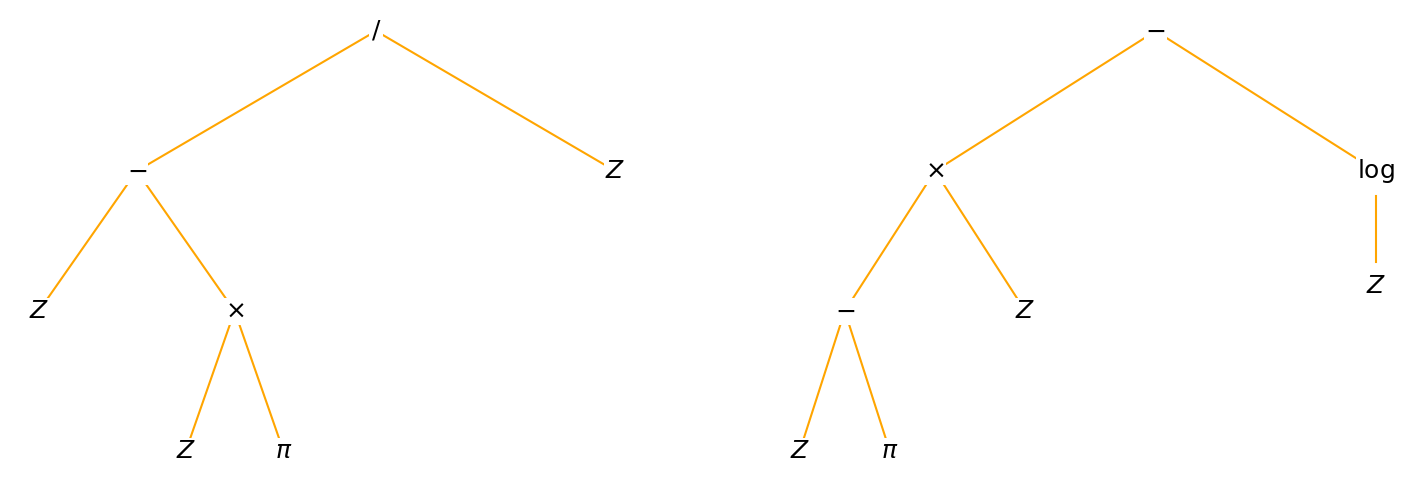

In [8]:
# Shows the graph
def show_graph(root:Node, root_x=0, root_y=0, level=1):
    plt.axis("off")
    dist_mid = np.sqrt(2)
    theta = 45/180 * np.pi / (0.6*level + 0.4) # I wanted do 1/level, but it was horrendous for big graphs
    font_space = 0.3
    color = "orange"
        
    # Plot node
    plt.text(root_x, root_y, f"${token2symbol[root.val]}$",
              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
              ha='center', va='center', 
             fontsize=18)
    
    # Plot children
    if root.left and root.right:
        x_left, y_left = root_x - dist_mid * np.tan(theta) + font_space, root_y - dist_mid - font_space
        x_right, y_right = root_x + dist_mid * np.tan(theta) - font_space, y_left
        
        # Show line and then recursively show left side
        plt.plot((root_x, x_left), (root_y, y_left), color=color)
        show_graph(root.left, x_left, y_left, level+1)
        
        # Show line and then recursively show right side
        plt.plot((root_x, x_right), (root_y, y_right), color=color)
        show_graph(root.right, x_right, y_right, level+1)
    elif root.right:
        x_mid, y_mid = root_x, root_y - dist_mid + font_space
        plt.plot((root_x, x_mid), (root_y-font_space, y_mid), color=color)
        # Recursively show graph
        show_graph(root.right, x_mid, y_mid-font_space, level+1)

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
show_graph(correct_graph)
plt.subplot(1,2,2)
show_graph(predict_graph)
plt.show()

# Tree Edit Distance Algorithm

<b>Node Insertion:</b> takes a node and puts a new node in between the current node and it's parent

        1         Insert Node 2 -> 2-4         1
       / \        ------------------->        / \
      2   3                                  4   3
           \                                /     \
            6                              2       6
            
What about the leaf nodes then? Well it will always be better to do a replace if necessary and then let the base case handle the rest

<b>Replace Node:</b> takes a node and the new value it should be given and then replaces the node's value

        1          Replace Node 5 -> 7         1
       / \        ------------------->        / \
      2   3                                  2   3
     / \   \                                / \   \
    4   5   6                              4   7   6


<b>Node Delete:</b> Deletes a node and replaces it with the right or left child with cost equal to the size of the other side

            1                        Delete Node 2,                    1
           / \                       replace with its                 / \
          2   3                      right child (5)                 5   3
         / \                         -------------->                / \
        4   5                                                      6   7
           / \
          6   7

Note that it does not make sense to make a ternary tree, as this would entail completely deleting one of the three branches which reduces to just introducing the cost described above

<b>Node Swap:</b> Swaps the left child with the right child of a node

         1                           Node Swap: swap                        1
       /   \                         subtrees 2 and 3                     /   \
      2     3                        -------------->                     3     2
     / \   / \                                                          / \   / \
    4   5 6   7                                                        6   7 4   5

In [9]:
class TreeEditDistance:
    def __init__(self):
        self.cache = {}
        
    def calculate(self, root_predict, root_correct):
        key = (",".join(graph_to_postfix(root_predict)), ",".join(graph_to_postfix(root_correct)))
        if key in self.cache:
            return self.cache[key]
        
        # Base case
        if not root_predict or not root_correct:
            return max(node_count(root_predict), node_count(root_correct))
        
        # Replace cost is 1 if the root nodes contain different values
        replace_cost = int(root_predict.val != root_correct.val)
        
        # Recurse and calculate the minimum distance
        min_dist = min( 
                       self.calculate(root_predict.left, root_correct.left) + self.calculate(root_predict.right, root_correct.right) + replace_cost, # Replace Node
                       self.calculate(root_predict.left, root_correct.right) + self.calculate(root_predict.right, root_correct.left) + replace_cost + (1 if not root_correct.val in commutative_operators else 0), # Replace Node + Swap Node
                       self.calculate(None, root_correct.left) + self.calculate(root_predict, root_correct.right) + 1, # Insert Node
                       self.calculate(root_predict.left, root_correct) + node_count(root_predict.right) + 1, # Delete Node and replace with left
                       self.calculate(root_predict.right, root_correct) + node_count(root_predict.left) + 1, # Delete Node and replace with right
                      )

        self.cache[key] = min_dist
        return min_dist

### Simple tests

In [18]:
# Main test - expected: 5
TED = TreeEditDistance()
TED.calculate(predict_graph, correct_graph)

5

In [19]:
# Test replace - expected: 1
TED.calculate(Node(TT_PLUS, Node(TT_INTEGER), Node(TT_PI)), Node(TT_PLUS, Node(TT_INTEGER), Node(TT_INTEGER)))

1

In [20]:
# Test delete - expected: 1
TED.calculate(Node(TT_MINUS, Node(TT_INTEGER), Node(TT_INTEGER)), Node(TT_MINUS, None, Node(TT_INTEGER)))

1

In [21]:
# Test insert - expected: 1
TED.calculate(Node(TT_MINUS, None, Node(TT_INTEGER)), Node(TT_MINUS, Node(TT_INTEGER), Node(TT_INTEGER)))

1

In [22]:
# Test child node swap, commutative - expected: 0
TED.calculate(Node(TT_PLUS, Node(TT_INTEGER), Node(TT_PI)), Node(TT_PLUS, Node(TT_PI), Node(TT_INTEGER)))

0

In [23]:
# Test child node swap, not commutative - expected: 1
TED.calculate(Node(TT_MINUS, Node(TT_INTEGER), Node(TT_PI)), Node(TT_MINUS, Node(TT_PI), Node(TT_INTEGER)))

1

In [24]:
# Test equal - expected: 0
TED.calculate(Node(TT_PLUS, Node(TT_INTEGER), Node(TT_PI)), Node(TT_PLUS, Node(TT_INTEGER), Node(TT_PI)))

0

In [26]:
# Overlapping subtree test - exptected: 6
TED.calculate(
    Node(TT_MULTIPLY, Node(TT_DIVIDE, Node(TT_LOG, None, Node(TT_SQRT, None, Node(TT_INTEGER))), Node(TT_INTEGER)), Node(TT_PI)),
    Node(TT_LOG, None, Node(TT_SQRT, None, Node(TT_PLUS, Node(TT_PI), Node(TT_INTEGER))))
)

6